# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
def load_data(folder='sentiment'):
    """
        Load data from the folder and stor it in the dictionary
        
        Parameters
        ----------
        
        folder: str, optional
            name of the folder to extract the data from. (default is to get sentiment data)
    
    """
    names = ['text', 'label']
    if folder=='topic':
        names = names[::-1]
    all_data = {}
    for file in ['train', 'dev', 'test']:
        all_data[file] = pd.read_csv(f'data_{folder}/{file}.csv', names=names)
    return all_data

In [3]:
data_files = load_data()

If you use Pandas you can see a sample of the data.

In [4]:
data_files['train'].head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [5]:
def get_raw_data(data_files):
    """
        Converts pandas data to lists
        
        Parameters
        ----------
        data_files: dict
            Dictionary containing pandas dataframes read from the data files
    """
    raw_data = {}
    for key, value in data_files.items():
        raw_data[f'X_{key}'] = value.text.values.tolist()
        raw_data[f'y_{key}'] = value.label.values
    return raw_data

In [6]:
raw_data = get_raw_data(data_files)

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [7]:
stop_words = set(['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by',
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its'])

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [8]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=set(), vocab=set()):
    """
        Extracts ngram representation of the text data from a string
        
        Parameters
        ----------
        x_raw: str
            String representign a single text file
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        vocab: set, optional
            a set of ngrams that should be kept (default is empty returning all ngrams)
    """
    
    # Tokenise the text
    tokens = re.findall(token_pattern, x_raw.lower()) # lowercase to reducde number of unique tokens
    
    # Remove the stop words
    no_stop = [word for word in tokens if word not in stop_words]
    
    # Create ngrams
    if ngram_range[0] == 1:
        ngram_range = (ngram_range[0]+1, ngram_range[1])
        ngrams = no_stop.copy()
    else:
        ngrams = []
        
    for n in range(ngram_range[0], ngram_range[1]+1):
        ngrams += zip(*[no_stop[i:] for i in range(n)])
    
    # Keep only ngrams that are in vocab:
    if vocab:
        ngrams = [ngram for ngram in ngrams if ngram in vocab]
        
    return ngrams

In [9]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [10]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=set()):
    
    """
        Extracts the full vocabluary of ngrams from a list of strings (texts)
        
        Parameters
        ----------
        X_raw: list[dtype=str]
            String to extrac the vocabluary from
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        min_df: int, optional
            minimum document frequency to keep the ngram in the vocabluary (default is 0 to keep all ngrams)
            
        keep_topN: int, optinal
            keep only top number of occuring ngrams (default is 0 to keep all ngrams)
    """
    
    df = Counter() 
    ngram_counts = Counter()
    
    # Extract the full vocabluary:
    for x in X_raw:
        ngrams = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        ngram_counts.update(ngrams)
        df.update(set(ngrams))
    
    # Keep only ngrams that occur in certain number of documents
    if min_df:
        df = Counter({k: v for k, v in df.items() if v >= min_df})
        ngram_counts = Counter({k: v for k, v in ngram_counts.items() if k in df.keys()})
    
    # Keep only ngrams that are common overall
    if keep_topN and keep_topN < len(df.keys()):
        ngram_counts = Counter(dict(ngram_counts.most_common()[:keep_topN]))
        df = Counter({k: v for k, v in df.items() if k in ngram_counts.keys()})
                
    return list(df.keys()), df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [12]:
vocab, df, ngram_counts = get_vocab(raw_data['X_train'], ngram_range=(1,3), stop_words=stop_words, keep_topN = 5000)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['big', 'degree', 'hear', ('film', 'only'), 'prince', 'wright', 'cast', 'see', 'fonda', 'disney', 'then', 'small', 'proving', 'recognition', 'only', 'course', 'pat', 'crazy', 'majority', 'legend', ('not', 'exactly'), 'spoilers', 'breathtaking', 'stuff', 'smart', 'drawn', 'mars', 'family', ('little', 'mermaid'), 'score', 'production', 'but', 'rather', 'desire', 'aware', 'human', 'voice', 'authority', 'context', 'unfortunate', 'beautiful', 'end', 'few', 'prior', 'heroine', 'real', 'screen', 'value', 'out', 'voiced', 'such', 'not', 'had', ('most', 'people'), 'full', 'beauty', 'many', 'wonderful', 'great', 'music', 'my', 'over', 'now', 'literally', ('there', 'no'), 'provides', 'direct', 'desperate', 'little', 'serious', 'meg', 'close', 'question', ('back', 'into'), 'roles', 'subsequent', 'their', 'throughout', 'say', 'started', 'major', 'kiss', 'distracting', 'perhaps', ('if', 'not'), 'tour', 'enough', 'no', 'away', 'public', ('not', 'only'), 'children', 'left', 'williams', 'storylin

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [13]:
id_word = dict(zip(range(len(vocab)), vocab))
word_id = dict(zip(vocab, range(len(vocab))))

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [14]:
from functools import partial

In [15]:
ngram_partial = partial(extract_ngrams, stop_words=stop_words, vocab=set(vocab))

In [16]:
ngram_data = {}
for key, value in raw_data.items():
    if key.startswith('X'):
        ngram_data[key] = list(map(ngram_partial, value))
    else:
        ngram_data[key] = value

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [17]:
def vectorise(X_ngram, vocab, word_id):
    """
        Obtains Bag-of-ngram representations for a list of documents
        
        Parameters:
        -----------
        X_ngram: list
            a list of texts (documents), where each text is represented as list of n-grams in the vocab
        
        vocab: set
            a set of n-grams to be used for representing the documents
        
        word_id: dict
            dictionary of coresponding word and their ids
    """
    
    X_vec = np.zeros(shape=(len(X_ngram), len(vocab)))
    
    for i, counts in enumerate(map(Counter, X_ngram)):
        for key, value in counts.items():
            X_vec[i, word_id[key]] = value
        
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [18]:
count_data = {}
for key, value in ngram_data.items():
    if key.startswith('X'):
        count_data[key] = vectorise(value, vocab, word_id)
    else:
        count_data[key] = value

In [19]:
count_data['X_train'].shape

(1400, 5000)

In [20]:
count_data['X_train'][1,:50]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 2., 0.])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

Then transform your count vectors to tf.idf vectors:

In [21]:
df_arr = np.array(list(df.values()))
N = count_data['X_train'].shape[0]

In [22]:
# Compute idf:
df_arr = np.array(list(df.values()))
N = count_data['X_train'].shape[0]
idf = np.log10(N / df_arr)

In [23]:
tfidf_data = {}
for key, value in count_data.items():
    if key.startswith('X'):
        tfidf_data[key] = value * idf
    else:
        tfidf_data[key] = value

In [24]:
tfidf_data['X_train'][1,:50]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30664999, 0.        , 0.        ,
       1.43467024, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.65476634, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.03218468,
       0.        , 0.04194441, 0.        , 0.        , 0.        ,
       0.        , 0.98776554, 1.73115469, 0.        , 0.        ,
       0.92341156, 0.        , 0.45240109, 0.        , 0.        ,
       0.50070577, 0.53974667, 0.        , 0.22540856, 0.        ])

#### Puting data extraction procedure together:

In [25]:
def get_data(folder, tfidf=False, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
             min_df=0, keep_topN=0, stop_words=set()):
    """
        Combines data extraction procedure into a single method
        
        Parameters
        ----------
        folder: str
            name of the folder to extract the data from
        
        tfidf: bool, optional
            determines tfidf should be used or not (defaults to False)
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        min_df: int, optional
            minimum document frequency to keep the ngram in the vocabluary (default is 0 to keep all ngrams)
            
        keep_topN: int, optinal
            keep only top number of occuring ngrams (default is 0 to keep all ngrams)
    """
    data_dict = {}
    
    data_files = load_data(folder=folder)
    raw_data = get_raw_data(data_files)
    
    vocab, df, ngram_counts = get_vocab(raw_data['X_train'], ngram_range=(1,3), stop_words=stop_words,
                                       token_pattern=token_pattern, min_df=min_df, keep_topN=keep_topN)
    
    df_arr = np.array(list(df.values()))
    N = len(raw_data['X_train'])
    idf = np.log10(N / df_arr)
    
    id_word = dict(zip(range(len(vocab)), vocab))
    word_id = dict(zip(vocab, range(len(vocab))))
    
    ngram_partial = partial(extract_ngrams, stop_words=stop_words, vocab=set(vocab))
    
    for key, value in raw_data.items():
        if key.startswith('X'):
            ngram_data = list(map(ngram_partial, value))
            count_data = vectorise(ngram_data, vocab, word_id)
            if tfidf:
                data_dict[key] = count_data * idf
            else:
                data_dict[key] = count_data
        else:
            data_dict[key] = value
    
    data_dict['id_word'] = id_word
    data_dict['word_id'] = word_id
    data_dict['vocab'] = np.array(vocab)
    
    return data_dict

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [26]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [27]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [28]:
def predict_proba(X, weights):
    return sigmoid(np.dot(X, weights))

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [29]:
def predict_class(X, weights):
    prob = predict_proba(X, weights)
    return np.where(prob>0.5, 1, 0)

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [30]:
def binary_loss(X, Y, weights, alpha=0.00001):
    prob = predict_proba(X, weights)
    l = -Y * np.log(prob) - ((1 - Y) * np.log(1 - prob))
    reg = 0.5 * alpha * np.sum(np.square(weights))
    return np.mean(l) + reg

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [31]:
def binary_grad(X, Y, weights, alpha=0.00001):
    grad = X.T * (predict_proba(X, weights) - Y)
    grad += (alpha * weights)
    return grad

In [32]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", num_classes=5, lr=0.1, 
        alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    """
        Performs Stochastic Gradient Descent optimization for classification task

        Parameters
        ----------
        X_tr: np.array
            training input data

        Y_tr: np.array
            training labels (first dimension should be equivalent to X_tr)

        X_dev: np.array, optional
            development input data for calculation of validation loss 

        Y_dev: np.array, optional
            development labels (only used if X_dev is suplied)

        loss: {'binary', 'categorical'}
            type of loss function to use (defaults to binary)

        num_classes: int, optional
            number of classes used in multiclass clasification (only used if loss is categorical)

        lr: float, optional
            learning rate to use durning training (default to optimal parameter determined durning hyperparameter optimization)

        alpha: float, optional
            regularization strenght (default to optimal)

        epochs: int, optional
            number of times to go over full dataset (defaults to optimal)

        tolerance: float, optional
            difference between concurent development losses at which to stop the training (default to 0.0001)

        print_progress: bool, optional
            where as to print the updates for each epoch (default to True)
    """
    
    training_loss_history = []
    validation_loss_history = []
    
    n_points, n_features = X_tr.shape
    
    # Assing the loss function
    if loss == 'binary':
        calc_loss = partial(binary_loss, alpha=alpha)
        grad = partial(binary_grad, alpha=alpha)
        weights = np.zeros(n_features)
    elif loss == 'categorical':
        calc_loss = partial(categorical_loss, num_classes=num_classes, alpha=alpha)
        grad = partial(categorical_grad, alpha=alpha)
        weights = np.zeros((n_features, num_classes))
    
    for epoch in range(epochs):
        
        tr_loss = 0
        rand_idx = np.random.permutation(n_points)
        
        # Peform the update
        for i in range(n_points):
            weights -= lr * grad(X_tr[i], Y_tr[i], weights)
        
        # Calculate training loss for epoch
        tr_loss = calc_loss(X_tr, Y_tr, weights)
        training_loss_history.append(tr_loss)
        
        # Calcualte validation loss for epoch
        if len(X_dev):
            val_loss = calc_loss(X_dev, Y_dev, weights)
            validation_loss_history.append(val_loss)
        
        if print_progress:
            print(f'Epoch: {epoch}| Training Loss: {tr_loss:.3f}| Validation loss: {val_loss:.3f}')
        
        if epoch and len(X_dev) and tolerance:
            if (validation_loss_history[-2] - val_loss) < tolerance:
                break
            
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [33]:
count_data = get_data('sentiment', stop_words=stop_words, keep_topN=10000)

In [34]:
w_count, loss_tr_count, dev_loss_count = SGD(count_data['X_train'], count_data['y_train'], 
                                             X_dev=count_data['X_dev'], Y_dev=count_data['y_dev'], 
                                             lr=0.0001, epochs=250, alpha=0.0006)

Epoch: 0| Training Loss: 1.196| Validation loss: 1.191
Epoch: 1| Training Loss: 1.136| Validation loss: 1.143
Epoch: 2| Training Loss: 1.075| Validation loss: 1.094
Epoch: 3| Training Loss: 1.021| Validation loss: 1.051
Epoch: 4| Training Loss: 0.974| Validation loss: 1.014
Epoch: 5| Training Loss: 0.930| Validation loss: 0.980
Epoch: 6| Training Loss: 0.891| Validation loss: 0.949
Epoch: 7| Training Loss: 0.855| Validation loss: 0.922
Epoch: 8| Training Loss: 0.822| Validation loss: 0.896
Epoch: 9| Training Loss: 0.791| Validation loss: 0.873
Epoch: 10| Training Loss: 0.763| Validation loss: 0.851
Epoch: 11| Training Loss: 0.737| Validation loss: 0.831
Epoch: 12| Training Loss: 0.712| Validation loss: 0.813
Epoch: 13| Training Loss: 0.689| Validation loss: 0.795
Epoch: 14| Training Loss: 0.667| Validation loss: 0.779
Epoch: 15| Training Loss: 0.647| Validation loss: 0.763
Epoch: 16| Training Loss: 0.627| Validation loss: 0.749
Epoch: 17| Training Loss: 0.609| Validation loss: 0.735
Ep

Epoch: 146| Training Loss: 0.126| Validation loss: 0.400
Epoch: 147| Training Loss: 0.125| Validation loss: 0.400
Epoch: 148| Training Loss: 0.125| Validation loss: 0.399
Epoch: 149| Training Loss: 0.124| Validation loss: 0.399
Epoch: 150| Training Loss: 0.123| Validation loss: 0.399
Epoch: 151| Training Loss: 0.122| Validation loss: 0.398
Epoch: 152| Training Loss: 0.122| Validation loss: 0.398
Epoch: 153| Training Loss: 0.121| Validation loss: 0.398
Epoch: 154| Training Loss: 0.120| Validation loss: 0.397
Epoch: 155| Training Loss: 0.120| Validation loss: 0.397
Epoch: 156| Training Loss: 0.119| Validation loss: 0.397
Epoch: 157| Training Loss: 0.118| Validation loss: 0.397
Epoch: 158| Training Loss: 0.118| Validation loss: 0.396
Epoch: 159| Training Loss: 0.117| Validation loss: 0.396
Epoch: 160| Training Loss: 0.116| Validation loss: 0.396
Epoch: 161| Training Loss: 0.116| Validation loss: 0.396
Epoch: 162| Training Loss: 0.115| Validation loss: 0.395
Epoch: 163| Training Loss: 0.11

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

In [35]:
def plot_results(losses, labels):
    for i, loss in enumerate(losses):
        plt.plot(loss, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Binary Loss')
    plt.title('Loss trough Training')
    plt.legend()
    plt.draw()

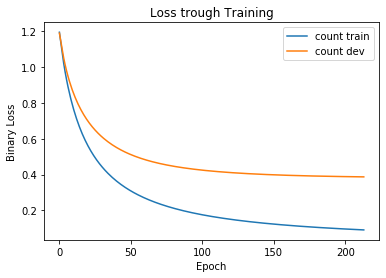

In [36]:
plot_results([loss_tr_count, dev_loss_count], ['count train', 'count dev'])

In [37]:
print(f'Difference between final development and training loss for count data is {dev_loss_count[-1] - loss_tr_count[-1]}')

Difference between final development and training loss for count data is 0.2964904986176096


**The model clearly overfits because the training loss is much smaller than development loss which means it is performing better on the training set**

Compute accuracy, precision, recall and F1-scores:

In [38]:
def evaluation_metrics(actual, predicted, average='binary'):
    acc = accuracy_score(actual, predicted)
    prec = precision_score(actual, predicted, average=average)
    rec = recall_score(actual, predicted, average=average)
    f1 = f1_score(actual, predicted, average=average)
    
    return [acc, prec, rec, f1]

In [39]:
count_pred = predict_class(count_data['X_test'], w_count)
count_metrics = evaluation_metrics(count_data['y_test'], count_pred)

results = pd.DataFrame(data=count_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                       columns=['count'])
results.round(2)

,count
Accuracy,0.86
Precision,0.89
Recall,0.82
F1-Score,0.85


Finally, print the top-10 words for the negative and positive class respectively.

In [40]:
def top_words(weights, vocab, n_classes=2):
    sorted_w = np.argsort(weights)
    top_positive = sorted_w[-10:][::-1]
    top_negative = sorted_w[:10]
    
    return vocab[top_positive], vocab[top_negative]

In [41]:
top_words_df = pd.DataFrame(index=['Top ' + str(i) for i in range(1, 11)],
                            columns=pd.MultiIndex.from_product([['count'], ['positive', 'negative']]))

pos, neg = top_words(w_count, count_data['vocab'])
top_words_df['count', 'positive'] = pos
top_words_df['count', 'negative'] = neg

In [42]:
top_words_df

count               
         positive       negative
Top 1       great            bad
Top 2        well  unfortunately
Top 3         fun          worst
Top 4        seen         script
Top 5        also           only
Top 6        many         boring
Top 7   perfectly            why
Top 8        both          looks
Top 9        life        nothing
Top 10        see           plot

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

**Some of the features would generalise as they represent a generally positive or negative sentiment. For example, *great* and *well* for the positive, and *bad* or *worst* for the negative. However, there are a few film-specific features such as *plot* or *script* that would not contribute anything to the new domain. This could be replaced by something like *design* for the laptop domain or *service* for the restaurant.**

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [43]:
tfidf_data = get_data('sentiment', tfidf=True, stop_words=stop_words, keep_topN=10000)

In [44]:
w_tfidf, trl, devl = SGD(tfidf_data['X_train'], tfidf_data['y_train'], 
                         X_dev=tfidf_data['X_dev'], Y_dev=tfidf_data['y_dev'], 
                         lr=0.0002, epochs=250, alpha=0.002)

Epoch: 0| Training Loss: 0.726| Validation loss: 0.775
Epoch: 1| Training Loss: 0.629| Validation loss: 0.721
Epoch: 2| Training Loss: 0.547| Validation loss: 0.670
Epoch: 3| Training Loss: 0.485| Validation loss: 0.630
Epoch: 4| Training Loss: 0.436| Validation loss: 0.600
Epoch: 5| Training Loss: 0.398| Validation loss: 0.575
Epoch: 6| Training Loss: 0.366| Validation loss: 0.556
Epoch: 7| Training Loss: 0.340| Validation loss: 0.539
Epoch: 8| Training Loss: 0.317| Validation loss: 0.526
Epoch: 9| Training Loss: 0.298| Validation loss: 0.514
Epoch: 10| Training Loss: 0.281| Validation loss: 0.504
Epoch: 11| Training Loss: 0.266| Validation loss: 0.495
Epoch: 12| Training Loss: 0.253| Validation loss: 0.487
Epoch: 13| Training Loss: 0.241| Validation loss: 0.480
Epoch: 14| Training Loss: 0.230| Validation loss: 0.474
Epoch: 15| Training Loss: 0.221| Validation loss: 0.468
Epoch: 16| Training Loss: 0.212| Validation loss: 0.463
Epoch: 17| Training Loss: 0.204| Validation loss: 0.458
Ep

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

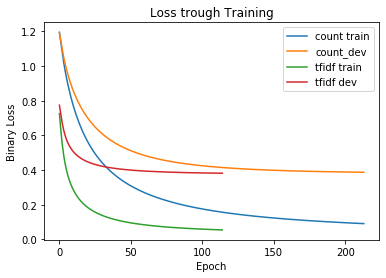

In [45]:
plot_results([loss_tr_count, dev_loss_count, trl, devl], 
             ['count train', 'count_dev', 'tfidf train', 'tfidf dev'])

In [46]:
print(f'Difference between final development and training loss for tfidf data is {devl[-1] - trl[-1]}')

Difference between final development and training loss for tfidf data is 0.3273070960965789


**We can see again that the model still overfits, even more than the count model. However, it is much faster to train and has better initial results than if using count data**

Compute accuracy, precision, recall and F1-scores:

In [47]:
tfidf_pred = predict_class(tfidf_data['X_test'], w_tfidf)
tfidf_metrics = evaluation_metrics(tfidf_data['y_test'], tfidf_pred)

results['tfidf'] = tfidf_metrics
results.round(3)

,count,tfidf
Accuracy,0.858,0.852
Precision,0.886,0.862
Recall,0.820,0.840
F1-Score,0.852,0.851


Print top-10 most positive and negative words:

In [48]:
pos, neg = top_words(w_tfidf, tfidf_data['vocab'])
top_words_df['tfidf', 'positive'] = pos
top_words_df['tfidf', 'negative'] = neg

In [49]:
top_words_df

count                      tfidf               
         positive       negative    positive       negative
Top 1       great            bad       great            bad
Top 2        well  unfortunately   hilarious          worst
Top 3         fun          worst   perfectly         boring
Top 4        seen         script    terrific       supposed
Top 5        also           only      truman  unfortunately
Top 6        many         boring         fun        nothing
Top 7   perfectly            why   memorable          harry
Top 8        both          looks     overall         stupid
Top 9        life        nothing  definitely            why
Top 10        see           plot        pulp         script

**With tfidf it becomes clear that some of the features that end up in the top 10 for the count are there just because they often occur in the text. For example: *many*, *also*, *only*. Those not necessarily contribute to making an accurate decision about sentiment and are replaced by more appropriate features when using tfidf.**

**It is also interesting to note that tfidf picks up more film-specific terms such as *pulp*, *Truman*, *hilarious*, which could potentially reduce the generalisation to other domains.**

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

In [50]:
from mpl_toolkits.mplot3d import Axes3D

In [51]:
def optimize(data, lr_range, epoch_range, alpha_range, loss='binary', num_classes=5, metric_average='binary', seed=333):
    
    if loss == 'binary':
        calc_loss = partial(binary_loss)
    elif loss == 'categorical':
        calc_loss = partial(categorical_loss, num_classes=num_classes)
    
    # Initialise the variables:
    lr3d, epoch3d = np.meshgrid(lr_range, epoch_range)
    lr_epoch_loss = np.empty_like(lr3d)
    dim = lr3d.shape
    metric_names = ['dev_loss', 'accuracy', 'precision', 'recall', 'F1']
    metrics = np.empty(shape=(dim[0], dim[1], len(metric_names)))
    
    print('Finding optimal epoch and learning rate')
    
    for i in range(dim[0]):
        for j in range(dim[1]):
            np.random.seed(seed)  # Ensure same random state is used for each run
            weights, _, _ = SGD(data['X_train'], data['y_train'],
                                lr=lr3d[i, j], epochs=epoch3d[i, j], alpha=0,
                                print_progress=False, loss=loss, num_classes=num_classes)
            metrics[i, j, 0] = calc_loss(data['X_dev'], data['y_dev'], weights, alpha=0)
            pred = predict_class(data['X_dev'], weights)
            metrics[i, j, 1:] = evaluation_metrics(data['y_dev'], pred, average=metric_average)
    
    results = np.hstack([lr3d.reshape(-1, 1), epoch3d.reshape(-1, 1), metrics.reshape(dim[0]*dim[1], -1)])
    lr_epoch_res = pd.DataFrame(data=results, columns=['lr', 'epochs']+metric_names)
    lr_epoch_res.sort_values(['dev_loss'], ascending=True, inplace=True)
    top_lr_epoch = lr_epoch_res.head(1)
    print(f'Best lr and epoch results, according to dev loss, for the development set:')
    print(top_lr_epoch)
    print('\n')
    
    print(f'Finding optimal alpha with best epochs and learning rate')
    a_metrics = np.empty(shape=(alpha_range.shape[0], len(metric_names)))
    for i, alpha in enumerate(alpha_range):
        np.random.seed(seed)
        weights, _, _ = SGD(data['X_train'], data['y_train'],
                            lr=top_lr_epoch['lr'].iloc[0], epochs=int(top_lr_epoch['epochs'].iloc[0]), alpha=alpha, 
                            print_progress=False, loss=loss, num_classes=num_classes)
        a_metrics[i, 0] = calc_loss(data['X_dev'], data['y_dev'], weights, alpha=0)
        pred = predict_class(data['X_dev'], weights)
        a_metrics[i, 1:] = evaluation_metrics(data['y_dev'], pred, average=metric_average)
    
    results = np.hstack([alpha_range.reshape(-1, 1), a_metrics])
    alpha_res = pd.DataFrame(data=results, columns=['alpha']+metric_names)
    alpha_res.sort_values(['dev_loss'], ascending=True, inplace=True)
    print(f'Best alpha results, according to F1 score and dev loss for the development set:')
    print(alpha_res.head(1))
    
    plot_opt_results(lr3d, epoch3d, metrics, alpha_range, a_metrics)
    
    return lr_epoch_res, alpha_res


def plot_opt_results(lr, epochs, lr_epoch_metric, alpha, alpha_metric):
    
   # Plot Epoch vs Learning Rate vs Loss graph
    fig = plt.figure(figsize=(16, 6))

    if epochs.shape[0] > 1:
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlabel('Learning Rate (x100)')
        ax.set_ylabel('Epochs')
        ax.set_zlabel('Negated Dev Loss')
        ax.plot_surface(lr*100, epochs, -lr_epoch_metric[:, :, 0], antialiased=True, cmap='summer')
    else:
        ax = fig.add_subplot(121)
        ax.set_xlabel('Learning Rate (x100)')
        ax.set_ylabel('Dev Loss')
        ax.set_title(f'Learning Rate vs Dev Loss for {epochs[0, 0]} epochs')
        ax.plot(lr.flatten()*100, lr_epoch_metric[:, :, 0].flatten())
    
    # Plot Alpha vs Loss graph for best epoch and lr combination.
    ax = fig.add_subplot(122)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Metrics')
    ax.set_title(f'Alpha for Different Metrics for best epoch and lr')
    ax.plot(alpha, alpha_metric[:, 0], label='dev_loss')
    # ax.plot(alpha, alpha_metric[:, 0], label='dev_loss')
    ax.legend()
    
    plt.show()

**To reduce computational overhead of hyperparameter search, I first examine the relation between epochs and learning rate picking the most optimal combination with regards to development loss. Then using those lr and epoch values I search for the optimal alpha again choosing value which minimises the development loss.**

### Define search space:

**Note: for the marking puprouses a single epoch value is evaluated which produces a 2D graph of lr vs devevelopment loss just for that epoch. As can be seen in the report, selecting a range of epochs will produce a 3D graph comparing all the different values. As well as that, a smaller range of learning rates is kept to reduce time for running the code**

In [52]:
# Values used in the report:
"""
lr_range = np.logspace(-5, -2, 10)
epoch_range = np.arange(100, 251, 50)
alpha_range = np.logspace(-4.5, -2, 10)
"""

# Values used for marking:
lr_range = np.array([0.00001, 0.0001, 0.001])
epoch_range = np.array([250])
alpha_range = np.array([0.00005, 0.001, 0.005])

### Optimising for the count data:

Finding optimal epoch and learning rate
Best lr and epoch results, according to dev loss, for the development set:
       lr  epochs  dev_loss  accuracy  precision  recall        F1
1  0.0001   250.0  0.381365     0.835   0.838384    0.83  0.834171


Finding optimal alpha with best epochs and learning rate
Best alpha results, according to F1 score and dev loss for the development set:
   alpha  dev_loss  accuracy  precision  recall        F1
1  0.001  0.381348     0.835   0.838384    0.83  0.834171


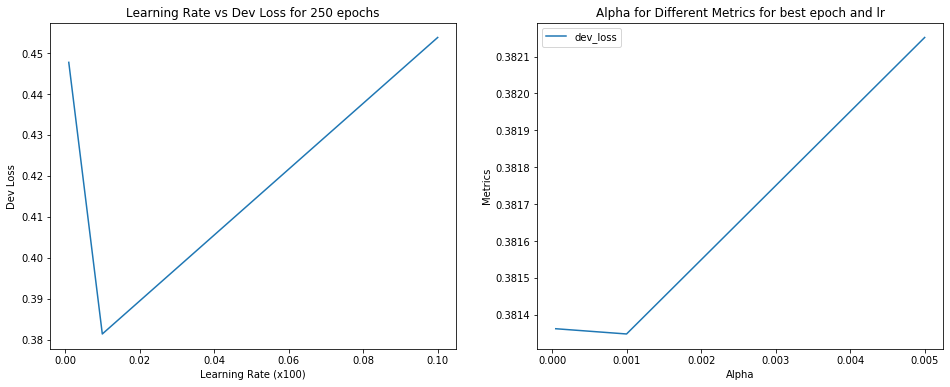

In [53]:
lr_epoch_count, alpha_count = optimize(count_data, lr_range, epoch_range, alpha_range)

In [54]:
lr_epoch_count.head()

,lr,epochs,dev_loss,accuracy,precision,recall,F1
1,0.00010,250.0,0.381365,0.835,0.838384,0.83,0.834171
0,0.00001,250.0,0.447723,0.830,0.830000,0.83,0.830000
2,0.00100,250.0,0.453803,0.845,0.841584,0.85,0.845771


In [55]:
alpha_count.head()

,alpha,dev_loss,accuracy,precision,recall,F1
1,0.00100,0.381348,0.835,0.838384,0.83,0.834171
0,0.00005,0.381362,0.835,0.838384,0.83,0.834171
2,0.00500,0.382152,0.830,0.836735,0.82,0.828283


### Optimising for the tfidf data:

Finding optimal epoch and learning rate
Best lr and epoch results, according to dev loss, for the development set:
       lr  epochs  dev_loss  accuracy  precision  recall        F1
1  0.0001   250.0  0.369122      0.84   0.826923    0.86  0.843137


Finding optimal alpha with best epochs and learning rate
Best alpha results, according to F1 score and dev loss for the development set:
     alpha  dev_loss  accuracy  precision  recall        F1
0  0.00005   0.36914      0.84   0.826923    0.86  0.843137


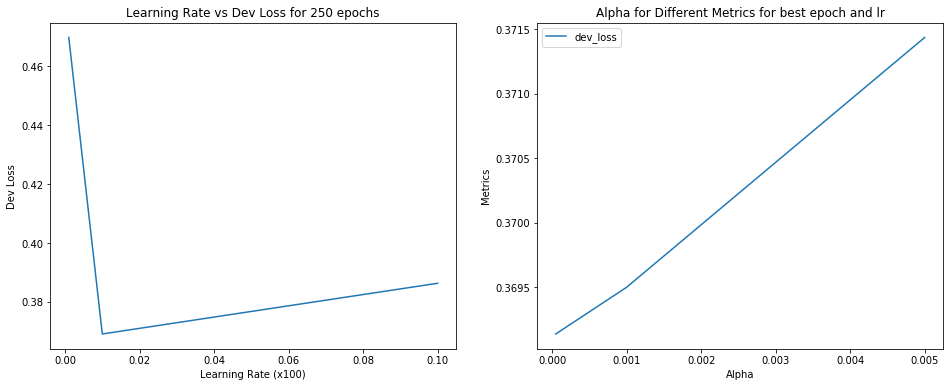

In [56]:
lr_epoch_tfidf, alpha_tfidf = optimize(tfidf_data, lr_range, epoch_range, alpha_range)

In [57]:
lr_epoch_tfidf.head()

,lr,epochs,dev_loss,accuracy,precision,recall,F1
1,0.00010,250.0,0.369122,0.840,0.826923,0.86,0.843137
2,0.00100,250.0,0.386326,0.855,0.838095,0.88,0.858537
0,0.00001,250.0,0.469708,0.825,0.803738,0.86,0.830918


In [58]:
alpha_tfidf.head()

,alpha,dev_loss,accuracy,precision,recall,F1
0,0.00005,0.369140,0.84,0.826923,0.86,0.843137
1,0.00100,0.369501,0.84,0.826923,0.86,0.843137
2,0.00500,0.371436,0.84,0.826923,0.86,0.843137


### Relation between learning rate and epochs:

**From the graphs above, there is no clear relationship between epoch and learning rate. However, in general, for higher epochs, a lower learning rate would be prefered up to an extent. It is clear from the graph that choosing too small of a learning rate drops of in loss achieved as SGD does not have time to reach the minimum. With larger learning rate, the minimum may be reached faster, but it will not necessarily be absolute minima as the loss will bounce around. The best solution for this would be to use an adjustable learning rate that reduces the number of epochs increases.**

### Effectiveness of regularization:

**Regularization improves the performance very slightly when a small value in the appropriate range is used. In theroy, it prevents overfitting, i.e., reduces the difference between loss for the training and development set. This is highlighted by the fact that tfidf was overfitting more and above parameter optimization procedure determined that a higher alpha is needed to reduce that effect.**

# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

In [59]:
classes = ['World', 'Sports', 'Business']

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [60]:
data_topic = load_data('topic')

In [61]:
data_topic['train'].head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [62]:
topic_raw = get_raw_data(data_topic)

In [63]:
vocab, df, ngram_counts = get_vocab(topic_raw['X_train'], ngram_range=(1,3), keep_topN=10000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

10000

['chavez', ('wing', 'president', 'hugo'), 'either', ('hugo', 'chavez', 'office'), 'numbers', ('president', 'hugo', 'chavez'), ('mandate', 'govern'), 'remove', 'new', ('chavez', 'office'), ('numbers', 'sunday', 'vote'), 'next', ('venezuelans', 'turned', 'out'), ('turned', 'out'), 'mandate', ('reuters', 'venezuelans'), 'president', ('numbers', 'sunday'), 'referendum', 'out', ('venezuelans', 'turned'), ('next', 'two', 'years'), 'sunday', 'historic', ('left', 'wing', 'president'), ('two', 'years'), 'turned', 'venezuelans', ('president', 'hugo'), 'him', 'govern', ('hugo', 'chavez'), ('give', 'him'), 'reuters', ('wing', 'president'), 'wing', ('next', 'two'), 'hugo', 'vote', 'left', 'office', ('sunday', 'vote'), 'years', 'give', 'early', ('left', 'wing'), 'two', 'large', 'least', 'reverse', 'troops', ('reuters', 'south'), 'protesters', 'more', 'central', 'police', 'controversial', 'decision', 'cannon', ('troops', 'iraq'), 'government', 'send', 'used', 'seoul', 'urging', 'korean', ('sou

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [64]:
def softmax(z):
    numerator = np.exp(z)
    if np.ndim(z) == 2:
        denominator = np.sum(np.exp(z), axis=1).reshape(-1, 1)
    else:
        denominator = np.sum(np.exp(z))
    return numerator/denominator

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [65]:
def predict_proba(X, weights):
    return softmax(np.dot(X, weights))

In [66]:
def predict_class(X, weights):
    prob = predict_proba(X, weights)
    return np.argmax(prob, axis=1) + 1

Toy example and expected functionality of the functions above:

In [67]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [68]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [69]:
predict_class(X, w)

array([2, 1, 1], dtype=int64)

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [70]:
def to_categorical(arr, num_classes):
    one_hot = np.zeros((arr.size, num_classes))
    one_hot[np.arange(arr.size), arr-1] = 1
    return one_hot

In [71]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    prob = predict_proba(X, weights)
    Y_cat = to_categorical(Y, num_classes)
    l = -Y_cat * np.log(prob)
    reg = 0.5 * alpha * np.sum(np.square(weights))
    return np.mean(np.sum(l, axis=1)) + reg 

In [80]:
X = np.array([0.1, 0.2])
Y = 2

prob = predict_proba(X, w)[Y-1]
X * (prob - 1)

array([-0.03318122, -0.06636245])

In [73]:
def categorical_grad(X, Y, weights, alpha=0.00001):
    prob = predict_proba(X, weights)[Y-1]
    grad = np.zeros_like(weights)
    grad[:, Y-1] = (prob - 1) * X
    grad[:, Y-1] += (alpha * weights[:, Y-1])
    return grad

Finally you need to modify SGD to support the categorical cross entropy loss:

**SGD function from previous section was adjusted to cope with both multiclass and binary task.**

**NOTE: the code should run sequentialy from top to bottom as there are repeatative function names**

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [74]:
topic_count = get_data('topic', stop_words=stop_words, keep_topN=10000)

In [75]:
w_count, loss_tr_count, dev_loss_count = SGD(topic_count['X_train'], topic_count['y_train'], 
                                             X_dev=topic_count['X_dev'], Y_dev=topic_count['y_dev'],
                                             lr=0.002, alpha=0, epochs=150,
                                             num_classes=3, loss='categorical')

Epoch: 0| Training Loss: 0.842| Validation loss: 0.949
Epoch: 1| Training Loss: 0.715| Validation loss: 0.851
Epoch: 2| Training Loss: 0.633| Validation loss: 0.780
Epoch: 3| Training Loss: 0.574| Validation loss: 0.726
Epoch: 4| Training Loss: 0.530| Validation loss: 0.684
Epoch: 5| Training Loss: 0.494| Validation loss: 0.651
Epoch: 6| Training Loss: 0.466| Validation loss: 0.623
Epoch: 7| Training Loss: 0.441| Validation loss: 0.599
Epoch: 8| Training Loss: 0.421| Validation loss: 0.579
Epoch: 9| Training Loss: 0.403| Validation loss: 0.562
Epoch: 10| Training Loss: 0.387| Validation loss: 0.547
Epoch: 11| Training Loss: 0.373| Validation loss: 0.533
Epoch: 12| Training Loss: 0.360| Validation loss: 0.521
Epoch: 13| Training Loss: 0.348| Validation loss: 0.511
Epoch: 14| Training Loss: 0.338| Validation loss: 0.501
Epoch: 15| Training Loss: 0.328| Validation loss: 0.492
Epoch: 16| Training Loss: 0.319| Validation loss: 0.484
Epoch: 17| Training Loss: 0.311| Validation loss: 0.476
Ep

Plot training and validation process and explain if your model overfit, underfit or is about right:

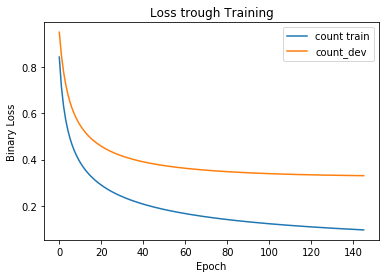

In [76]:
plot_results([loss_tr_count, dev_loss_count], 
             ['count train', 'count_dev'])

In [77]:
print(f'Difference between final development and training loss for count data is {dev_loss_count[-1] - loss_tr_count[-1]}')

Difference between final development and training loss for count data is 0.23391316912069576


**The model is overfitting again with continiuous improvement in the training loss and clear convergence of the development loss.**

Compute accuracy, precision, recall and F1-scores:

In [78]:
count_pred = predict_class(topic_count['X_test'], w_count)
count_metrics = evaluation_metrics(topic_count['y_test'], count_pred, average='macro')

results = pd.DataFrame(data=count_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                       columns=['count'])
results.round(3)

,count
Accuracy,0.844
Precision,0.849
Recall,0.844
F1-Score,0.845


Print the top-10 words for each class respectively.

In [79]:
def top_words(weights, vocab):
    top_10 = np.empty((10, weights.shape[1]), np.int32)
    for i, w in enumerate(weights.T):
        sorted_w = np.argsort(w)
        top_10[:, i] = sorted_w[-10:][::-1]
    return np.array(vocab)[top_10]

In [80]:
top10_count = top_words(w_count, topic_count['vocab'])
top_words_df = pd.DataFrame(data=top10_count, index=['Top ' + str(i) for i in range(1, 11)],
                            columns=pd.MultiIndex.from_product([['count'], classes]))
top_words_df

count                      
          World     Sports   Business
Top 1   tuesday     athens    reuters
Top 2      said    tuesday       said
Top 3   reuters         ap    tuesday
Top 4       new      after        new
Top 5    athens    reuters        oil
Top 6     after    olympic      after
Top 7        ap        new     prices
Top 8       oil       team         us
Top 9    greece      first        but
Top 10   monday  wednesday  wednesday

**Each category mostly consists of domain-specific terms which makes sense in the context of multiclass classification. Thus this model would not generalize well at all to other topics unless appropriate changes were made to add support for additional classes. There are a few terms which occur at the top in all 3 categories such as *reuters* and *tuesday*. Those are likely to cause a problem for distinguishing between classes. This is likely occurring because those words are common in the document and should be brought further down the list when using tfidf.**

In [81]:
topic_tfidf = get_data('topic', tfidf=True, stop_words=stop_words, keep_topN=10000)

In [82]:
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(topic_tfidf['X_train'], topic_tfidf['y_train'], 
                                             X_dev=topic_tfidf['X_dev'], Y_dev=topic_tfidf['y_dev'],
                                             lr=0.002, alpha=0, epochs=100,
                                             num_classes=3, loss='categorical')

Epoch: 0| Training Loss: 0.600| Validation loss: 0.778
Epoch: 1| Training Loss: 0.450| Validation loss: 0.644
Epoch: 2| Training Loss: 0.369| Validation loss: 0.567
Epoch: 3| Training Loss: 0.318| Validation loss: 0.516
Epoch: 4| Training Loss: 0.282| Validation loss: 0.480
Epoch: 5| Training Loss: 0.254| Validation loss: 0.453
Epoch: 6| Training Loss: 0.232| Validation loss: 0.431
Epoch: 7| Training Loss: 0.214| Validation loss: 0.413
Epoch: 8| Training Loss: 0.199| Validation loss: 0.399
Epoch: 9| Training Loss: 0.187| Validation loss: 0.386
Epoch: 10| Training Loss: 0.176| Validation loss: 0.375
Epoch: 11| Training Loss: 0.166| Validation loss: 0.366
Epoch: 12| Training Loss: 0.157| Validation loss: 0.358
Epoch: 13| Training Loss: 0.150| Validation loss: 0.351
Epoch: 14| Training Loss: 0.143| Validation loss: 0.344
Epoch: 15| Training Loss: 0.137| Validation loss: 0.338
Epoch: 16| Training Loss: 0.131| Validation loss: 0.333
Epoch: 17| Training Loss: 0.126| Validation loss: 0.328
Ep

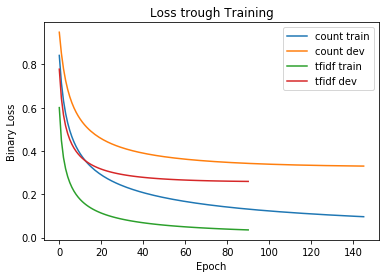

In [83]:
plot_results([loss_tr_count, dev_loss_count, loss_tr_tfidf, dev_loss_tfidf], 
             ['count train', 'count dev', 'tfidf train', 'tfidf dev'])

In [84]:
print(f'Difference between final development and training loss for tfidf data is {dev_loss_tfidf[-1] - loss_tr_tfidf[-1]}')

Difference between final development and training loss for tfidf data is 0.22410186819653413


**There is still a clear sign of overfitting for tfidf model, but it is slightly less significant than when using count data. Overall the performance of the tfidf model is superior, showing the importance of reduction in the contribution of standard terms when attempting to distinguish between multiple complex classes.**

In [85]:
tfidf_pred = predict_class(topic_tfidf['X_test'], w_tfidf)
tfidf_metrics = evaluation_metrics(topic_tfidf['y_test'], tfidf_pred, average='macro')

results['tfidf'] = tfidf_metrics
results.round(3)

,count,tfidf
Accuracy,0.844,0.864
Precision,0.849,0.867
Recall,0.844,0.864
F1-Score,0.845,0.864


In [86]:
top10_tfidf = top_words(w_tfidf, topic_tfidf['vocab'])
top_words_df = top_words_df.join(pd.DataFrame(data=top10_tfidf, index=['Top ' + str(i) for i in range(1, 11)],
                                 columns=pd.MultiIndex.from_product([['tfidf'], classes])))
top_words_df

count                                   tfidf            \
          World     Sports   Business             World    Sports   
Top 1   tuesday     athens    reuters           tuesday    athens   
Top 2      said    tuesday       said            greece        ap   
Top 3   reuters         ap    tuesday              said   olympic   
Top 4       new      after        new  (athens, greece)      team   
Top 5    athens    reuters        oil               oil    greece   
Top 6     after    olympic      after               afp  olympics   
Top 7        ap        new     prices            athens     after   
Top 8       oil       team         us                ap       two   
Top 9    greece      first        but           olympic     night   
Top 10   monday  wednesday  wednesday             after     first   

                       
             Business  
Top 1             oil  
Top 2          prices  
Top 3             new  
Top 4         company  
Top 5            said  
Top 6         reuters  
Top 7              us  
Top 8             but  
Top 9          google  
Top 10  (oil, prices)

**Although *Tuesday* stayed on the top of world category, it has been entirely removed from top 10 of other categories showing that it might still be a vital sign that the topic is related to the world new but not so relevant for other classes. *Reuters* also entirely went out of the picture thanks to tfidf. Nevertheless, again, tfidf has even more domain-specific terms in top 10 and so would not generalize well to other topics at all. If as an example we would add a scientific news class more appropriate terms could be *discovery*, *publication*, *launch*, etc.**

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

**Same optimization approach was used as for the previous task with similar parameter range for consistency**

In [87]:
# Values used in the report:
"""
lr_range = np.logspace(-4, -1.5, 10)
epoch_range = np.arange(100, 251, 50)
alpha_range = np.logspace(-4, -2, 10)
"""

# Values used for marking:
lr_range = np.array([0.0001, 0.01, 0.02])
epoch_range = np.array([100])
alpha_range = np.array([0.0001, 0.001, 0.01])

### Optimizing for count data:

Finding optimal epoch and learning rate
Best lr and epoch results, according to dev loss, for the development set:
     lr  epochs  dev_loss  accuracy  precision  recall       F1
1  0.01   100.0  0.350542       0.9   0.908373     0.9  0.90121


Finding optimal alpha with best epochs and learning rate
Best alpha results, according to F1 score and dev loss for the development set:
   alpha  dev_loss  accuracy  precision  recall       F1
1  0.001  0.341097       0.9   0.908373     0.9  0.90121


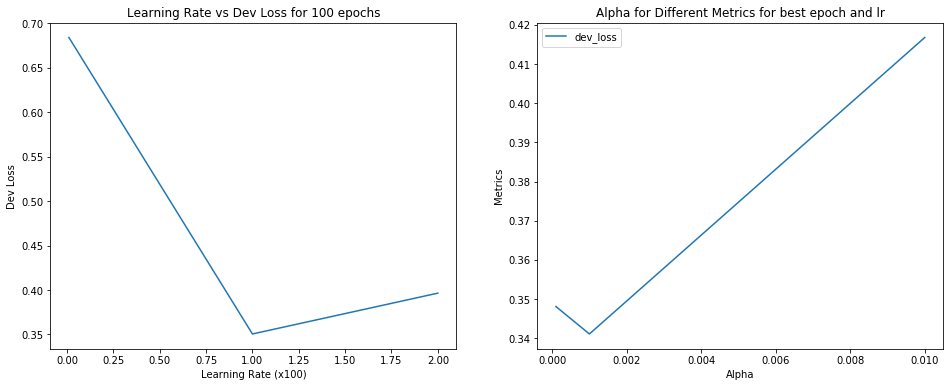

In [88]:
lr_epoch_count, alpha_count = optimize(topic_count, lr_range, epoch_range, alpha_range, loss='categorical', num_classes=3, metric_average='macro')

In [89]:
lr_epoch_count.head()

,lr,epochs,dev_loss,accuracy,precision,recall,F1
1,0.0100,100.0,0.350542,0.900000,0.908373,0.900000,0.901210
2,0.0200,100.0,0.396481,0.893333,0.906717,0.893333,0.894919
0,0.0001,100.0,0.684220,0.866667,0.877756,0.866667,0.868179


In [90]:
alpha_count.head()

,alpha,dev_loss,accuracy,precision,recall,F1
1,0.0010,0.341097,0.9,0.908373,0.9,0.901210
0,0.0001,0.348110,0.9,0.908373,0.9,0.901210
2,0.0100,0.416761,0.9,0.907689,0.9,0.901333


### Optimizing for tfidf data:

Finding optimal epoch and learning rate
Best lr and epoch results, according to dev loss, for the development set:
     lr  epochs  dev_loss  accuracy  precision    recall        F1
1  0.01   100.0  0.298644  0.906667   0.916114  0.906667  0.907979


Finding optimal alpha with best epochs and learning rate
Best alpha results, according to F1 score and dev loss for the development set:
   alpha  dev_loss  accuracy  precision    recall        F1
1  0.001  0.294572  0.906667   0.916114  0.906667  0.907979


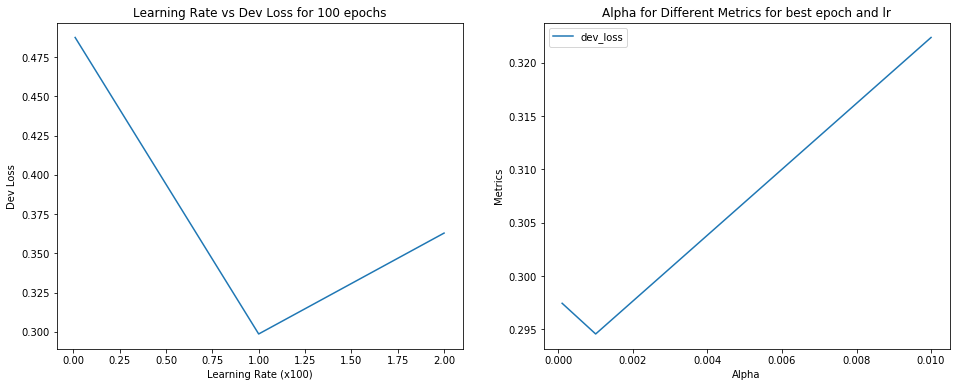

In [91]:
lr_epoch_tfidf, alpha_tfidf = optimize(topic_tfidf, lr_range, epoch_range, alpha_range, loss='categorical', num_classes=3, metric_average='macro')

In [92]:
lr_epoch_tfidf.head()

,lr,epochs,dev_loss,accuracy,precision,recall,F1
1,0.0100,100.0,0.298644,0.906667,0.916114,0.906667,0.907979
2,0.0200,100.0,0.362898,0.893333,0.910422,0.893333,0.895049
0,0.0001,100.0,0.487484,0.946667,0.946667,0.946667,0.946667


In [93]:
alpha_tfidf.head()

,alpha,dev_loss,accuracy,precision,recall,F1
1,0.0010,0.294572,0.906667,0.916114,0.906667,0.907979
0,0.0001,0.297450,0.906667,0.916114,0.906667,0.907979
2,0.0100,0.322378,0.940000,0.942130,0.940000,0.940345


### Relation between learning rate and epochs:

**The graph for this task looks completely different, which is likely due to inappropriate selection of search space for the parameters. Although likely, the search has not converged on the optimal solution; it is appropriate to assume increasing learning rate any further would soon result in a gradual reduction in performance, eventually forming similar graph as in the previous task. This time the peak performance has been obtained at a smaller epoch number with a relatively large learning rate.**

### Effectiveness of regularization:

**As graphs display, there is almost no benefit of regularization in this task even when a tiny alpha is chosen. The top few results from the tables further demonstrate this with metrics staying identical throughout. There is a hint of a small dip for the count data; however, it is on such a small scale that it is hard to judge its impact. It has been observed that slightly increasing regularization improved the metrics for the final test results, but at that point, it could be considered as overfitting for the test data. Thus regularization was parameter set to 0 for this task.**